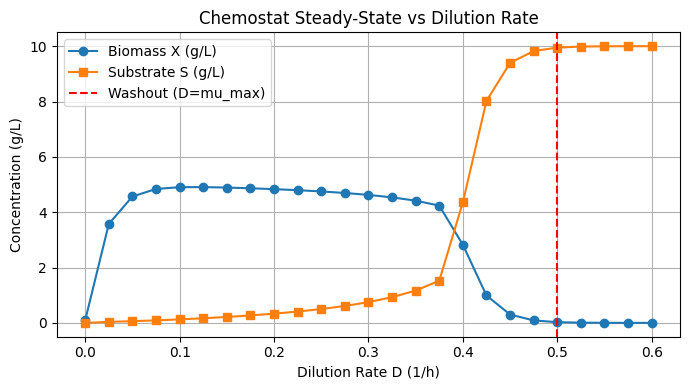

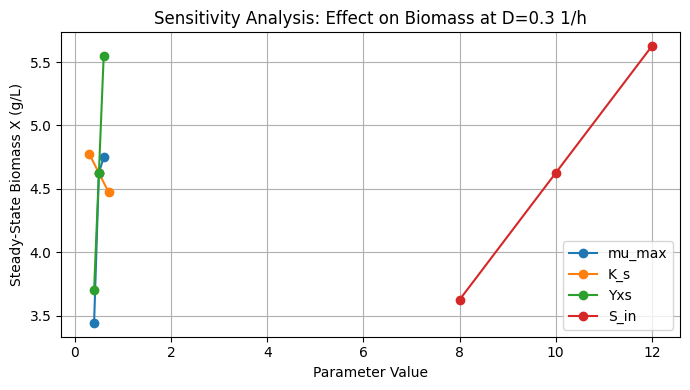

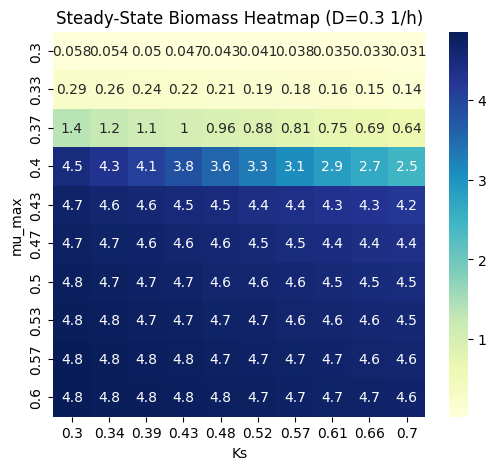

In [2]:
# ===============================
# Chemostat Simulation + Sensitivity Analysis
# ===============================
# Author: Your Name
# Purpose: Simulate continuous fermentation (chemostat) with Monod kinetics
# and perform sensitivity analysis on key parameters.
# -------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import seaborn as sns

# -------------------------------
# 1. Define Monod kinetics and chemostat ODEs
# -------------------------------
def mu(S, mu_max, K_s):
    """Monod specific growth rate"""
    return mu_max * S / (K_s + S + 1e-12)

def chemostat_ode(y, t, D, S_in, mu_max, K_s, Yxs):
    """ODE system for chemostat"""
    X, S = y
    dXdt = (mu(S, mu_max, K_s) - D) * X
    dSdt = D * (S_in - S) - (mu(S, mu_max, K_s)/Yxs) * X
    return [dXdt, dSdt]

# -------------------------------
# 2. Default Parameters
# -------------------------------
mu_max = 0.5      # 1/h
K_s = 0.5         # g/L
Yxs = 0.5         # g biomass / g substrate
S_in = 10.0       # g/L
X0 = 0.1          # g/L
S0 = 0.0          # g/L (initial substrate in reactor)
t = np.linspace(0, 50, 1000)  # hours

# -------------------------------
# 3. Sweep Dilution Rate D
# -------------------------------
D_vals = np.linspace(0, 0.6, 25)  # 0 to slightly above mu_max
X_ss = []  # steady-state biomass
S_ss = []  # steady-state substrate

for D in D_vals:
    y0 = [X0, S0]
    sol = odeint(chemostat_ode, y0, t, args=(D, S_in, mu_max, K_s, Yxs))
    X = sol[:,0]
    S = sol[:,1]
    X_ss.append(X[-1])
    S_ss.append(S[-1])

# -------------------------------
# 4. Plot Biomass and Substrate vs D
# -------------------------------
plt.figure(figsize=(7,4))
plt.plot(D_vals, X_ss, marker='o', label='Biomass X (g/L)')
plt.plot(D_vals, S_ss, marker='s', label='Substrate S (g/L)')
plt.axvline(mu_max, color='r', linestyle='--', label='Washout (D=mu_max)')
plt.xlabel('Dilution Rate D (1/h)')
plt.ylabel('Concentration (g/L)')
plt.title('Chemostat Steady-State vs Dilution Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Sensitivity Analysis (Single Parameters)
# -------------------------------
params = {
    'mu_max': [0.4, 0.5, 0.6],
    'K_s': [0.3, 0.5, 0.7],
    'Yxs': [0.4, 0.5, 0.6],
    'S_in': [8, 10, 12]
}

sensitivity_results = {}

for param_name, values in params.items():
    ss_X = []
    for val in values:
        # set parameters
        mu_m = mu_max if param_name != 'mu_max' else val
        Ks = K_s if param_name != 'K_s' else val
        Y = Yxs if param_name != 'Yxs' else val
        Sfeed = S_in if param_name != 'S_in' else val

        y0 = [X0, S0]
        sol = odeint(chemostat_ode, y0, t, args=(0.3, Sfeed, mu_m, Ks, Y)) # D fixed at 0.3
        X = sol[:,0]
        ss_X.append(X[-1])

    sensitivity_results[param_name] = ss_X

# -------------------------------
# 6. Plot Sensitivity
# -------------------------------
plt.figure(figsize=(7,4))
for param_name, values in sensitivity_results.items():
    plt.plot(params[param_name], values, marker='o', label=param_name)
plt.xlabel('Parameter Value')
plt.ylabel('Steady-State Biomass X (g/L)')
plt.title('Sensitivity Analysis: Effect on Biomass at D=0.3 1/h')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 7. Optional: 2D Heatmap of μmax vs Ks
# -------------------------------
mu_vals = np.linspace(0.3, 0.6, 10)
Ks_vals = np.linspace(0.3, 0.7, 10)
X_matrix = np.zeros((len(mu_vals), len(Ks_vals)))

for i, mu_m in enumerate(mu_vals):
    for j, Ks in enumerate(Ks_vals):
        y0 = [X0, S0]
        sol = odeint(chemostat_ode, y0, t, args=(0.3, S_in, mu_m, Ks, Yxs))
        X_matrix[i,j] = sol[-1,0]

plt.figure(figsize=(6,5))
sns.heatmap(X_matrix, xticklabels=np.round(Ks_vals,2), yticklabels=np.round(mu_vals,2),
            cmap='YlGnBu', annot=True)
plt.xlabel('Ks')
plt.ylabel('mu_max')
plt.title('Steady-State Biomass Heatmap (D=0.3 1/h)')
plt.show()
